# 🙋‍♂️ Preamble 🙋‍♂️ #

Name : Ayoub Choukri 

Date : 23 November 2023

Subject : Predicting Gestational Diabetes.

**🤞Note🤞** : This notebook is a part of a series of notebooks that I will be publishing on my [Github]() and [Kaggle]() accounts. Please feel free to check them out and give me your feedback.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msn
import pandas as pd
import sklearn as sk
import statsmodels.api as sm

# 💉General Context💉

Being my self Diabetic Type I, I always wanted to know more about the disease and how it can be predicted. So I decided to apply some basic skills in Data Science to try to predict Gestational Diabetes.

In this notebook, I will use Linear Discrimlinant Analysis (LDA) and Logistic Regression to predict Gestational Diabetes.

The notebbok that I will be using is the following : [Gestational Diabetes](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

## About Dataset

### Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

### Content

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

### Original Source

The original dataset is available at [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/pima+indians+diabetes)


<p align="center">
    <img src="https://media.tenor.com/oWep47R4zd0AAAAC/diabetes-patient-diabetes.gif.gif" alt="Gif">
</p>

# 📊Importing The Data Set📊 

In [3]:
data = pd.read_csv("/kaggle/input/pima-indians-diabetes-database/diabetes.csv")
pd.set_option('display.max_columns',None)
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

# 🧹Data Preprocessing🧹

Let's take a look to ou DataSet

In [4]:

data.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
693,7,129,68,49,125,38.5,0.439,43,1
402,5,136,84,41,88,35.0,0.286,35,1
666,4,145,82,18,0,32.5,0.235,70,1
179,5,130,82,0,0,39.1,0.956,37,1
588,3,176,86,27,156,33.3,1.154,52,1


In [5]:
data.shape

(768, 9)

> Our DataSet is composed of 768 rows and 9 columns. Each line represents a female patient. The columns are the following :
* **Pregnancies** : Number of times pregnant
* **Glucose** : Plasma glucose concentration at 2 hours in an oral glucose tolerance test
* **BloodPressure** : Diastolic blood pressure (mm Hg)
* **SkinThickness**: Triceps skin fold thickness (mm)
* **Insulin** : 2-Hour serum insulin (mu U/ml)
* **BMI** : Body mass index (weight in kg/(height in m)^2)
* **DiabetesPedigreeFunction** : Diabetes pedigree function
* **Age** : Age (years)
* **Outcome** : Class variable (0 : non-diabetic, 1 : diabetic)

Let's put each variable in its right dtype.


> Note that despite the fact that **Preganncies ** is a contable quantitative variable, we will not consider it as a categorical variable. We will keep it as a numeric variable.

In [6]:
df=data.copy()
categorical_columns = ['Outcome']
numerical_columns=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']
df[categorical_columns] = df[categorical_columns].astype('category')
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric, errors='coerce')

## Missing Values

<Axes: >

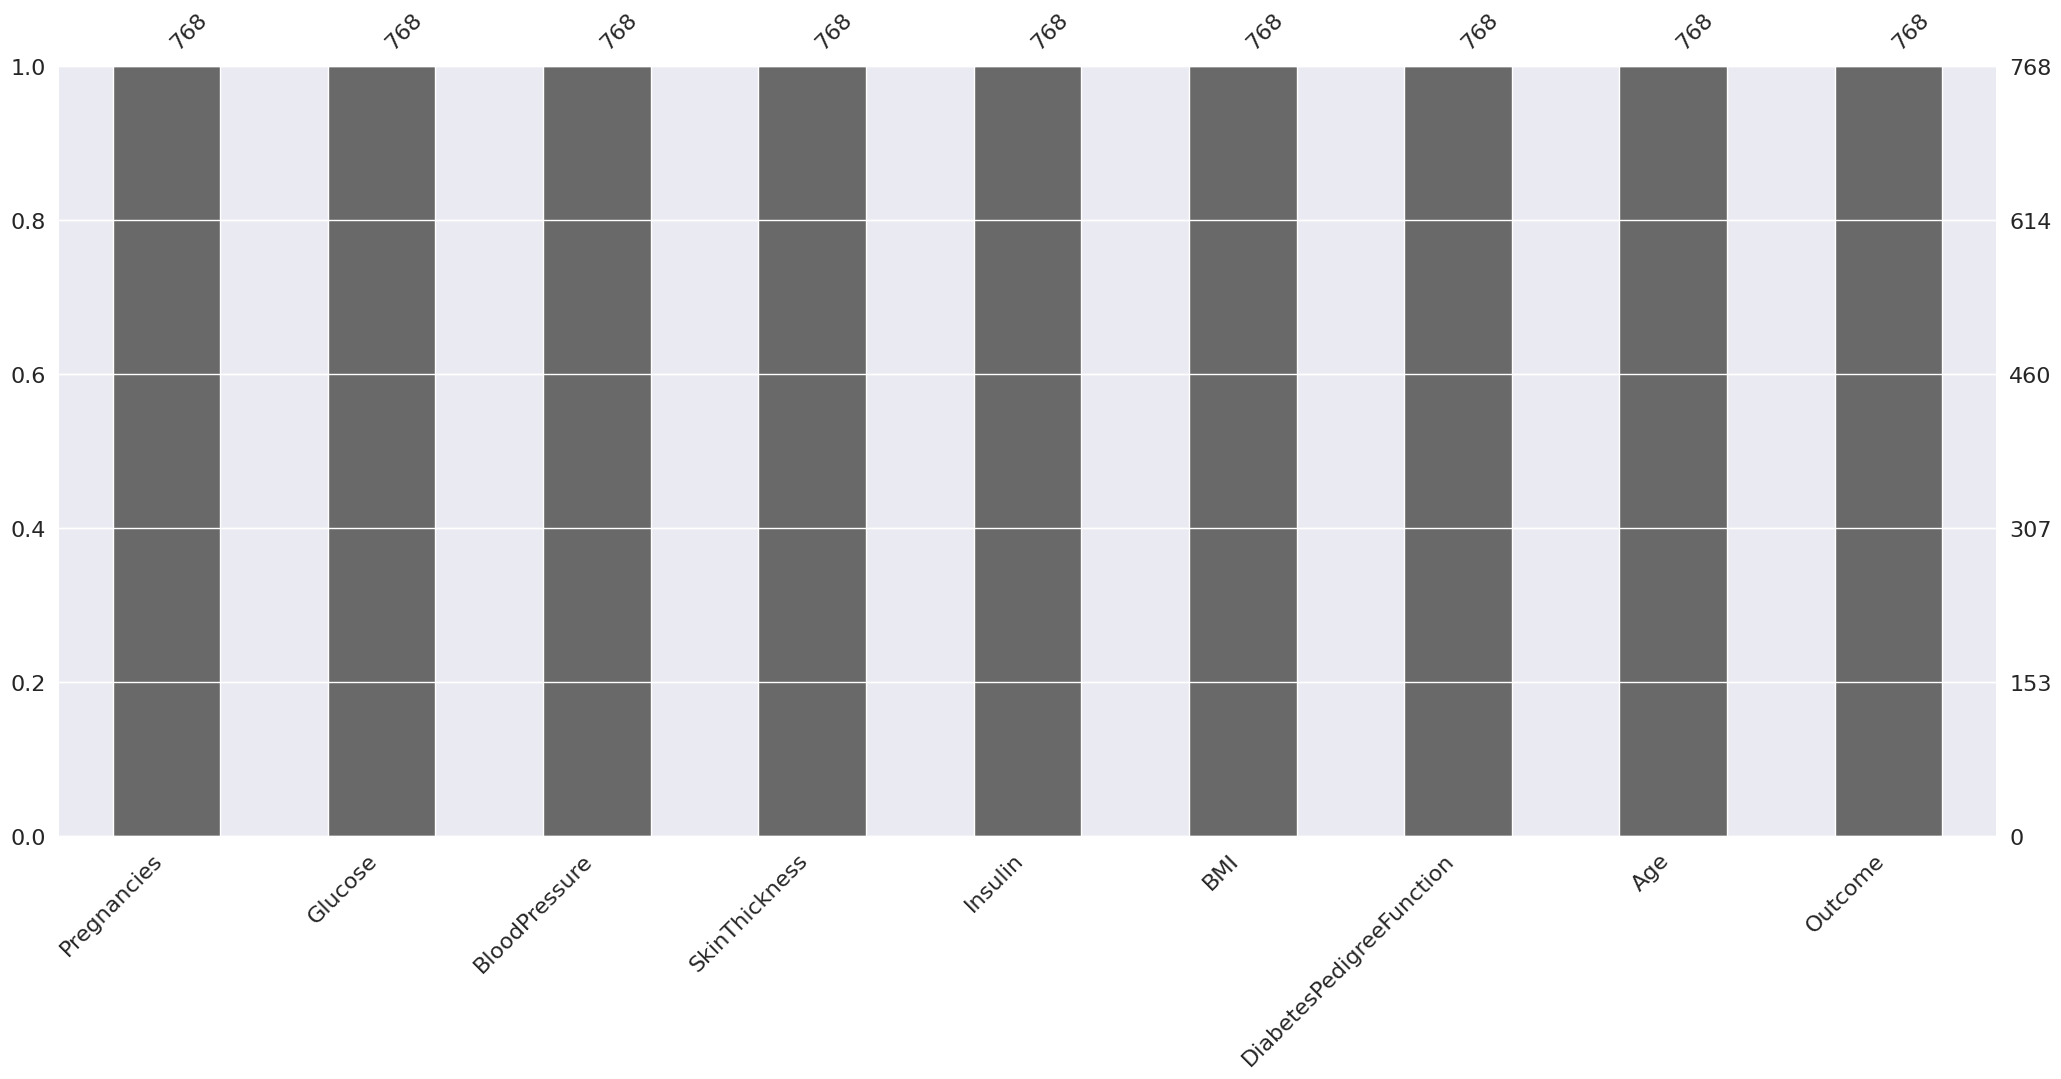

In [7]:
msn.bar(df)

> We can see that there are no missing values in our DataSet.

# 📊📈 Descriptive Analysis📊📈

### Boxplots and Outliers

In [8]:
def boxplot(data,variables,rotation=75,size=(8,6)):
    fig ,ax = plt.subplots(1,1,figsize=size)
    sns.boxplot(data[variables],ax=ax)
    ax.tick_params(rotation=rotation)
    plt.title("Box plot of numerical columns")
    return ax;

<Axes: title={'center': 'Box plot of numerical columns'}>

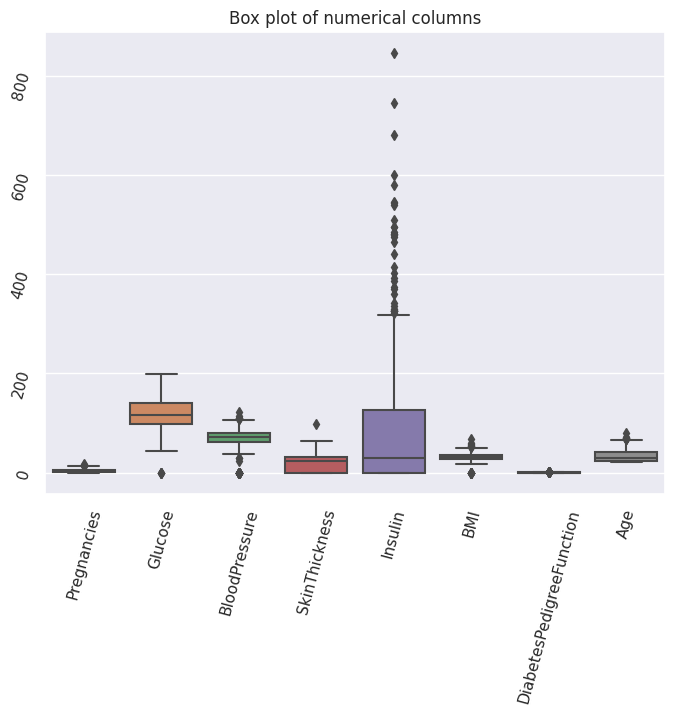

In [9]:
boxplot(data=df,variables=numerical_columns)


> Considering the fact that our variables have different units, it is quite logical that the boxplots are crushed. We will therefore apply the $log$ function to the variables that are crushed.

> We seen that there are some zeros in the variables **Glucose**, **BloodPressure**, **SkinThickness**, **Insulin** and **BMI**. These zeros are not normal and they are considered as outliers. We will replace them by the KN-Neighbors mean.
> 

In [10]:
aux_columns = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

def replace_zero(data, variables):
    for i in variables:
        data[i] = data[i].replace(0, np.nan)
    return data;

df = replace_zero(df, aux_columns)

In [11]:

from sklearn.impute import KNNImputer

# Assuming df is your DataFrame and it's already defined
imputer = KNNImputer(n_neighbors=10)
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])


In [12]:
df_scaled = df.copy()
df_scaled[numerical_columns] = (df_scaled[numerical_columns] - df_scaled[numerical_columns].mean()) / df_scaled[numerical_columns].std()

<Axes: title={'center': 'Box plot of numerical columns'}>

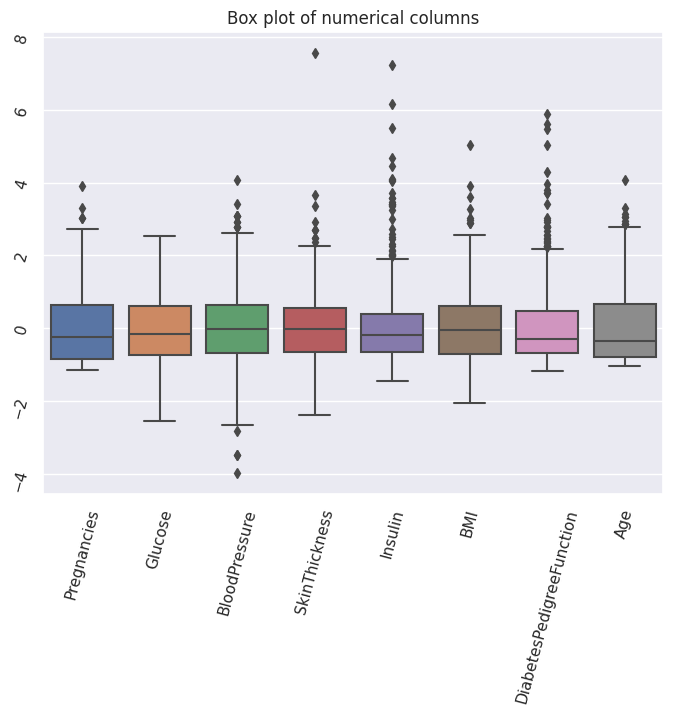

In [13]:
boxplot(data=df_scaled,variables=numerical_columns)

We can see that there are some outliers in our DataSet. We will not remove them at this stage. We will see later if we need to remove them or not.

## 🔢📏 Quantitative Variables🔢📏

### Densities

I will estimate the density of the numerical columns using the kernel density estimation method.

In [14]:
def density(data, plot_variables, size, color_bins, color_density,l, c, nmax=None):
    fig, axes = plt.subplots(l, c, figsize=size)
    for i in range(l):
        for j in range(0, c):
            variable = data[plot_variables[c*i+j]]
            q75, q25 = np.percentile(variable, [75 ,25])
            iqr = q75 - q25
            bin_width = (2 * iqr) / (len(variable) ** (1/3))
            
            sns.histplot(variable, ax=axes[i, j], color=color_bins,line_kws={"color" : color_density} ,fill=True, kde=True, binwidth=bin_width)
            axes[i, j].set_title(f"Density plot of {plot_variables[c*i+j]}")



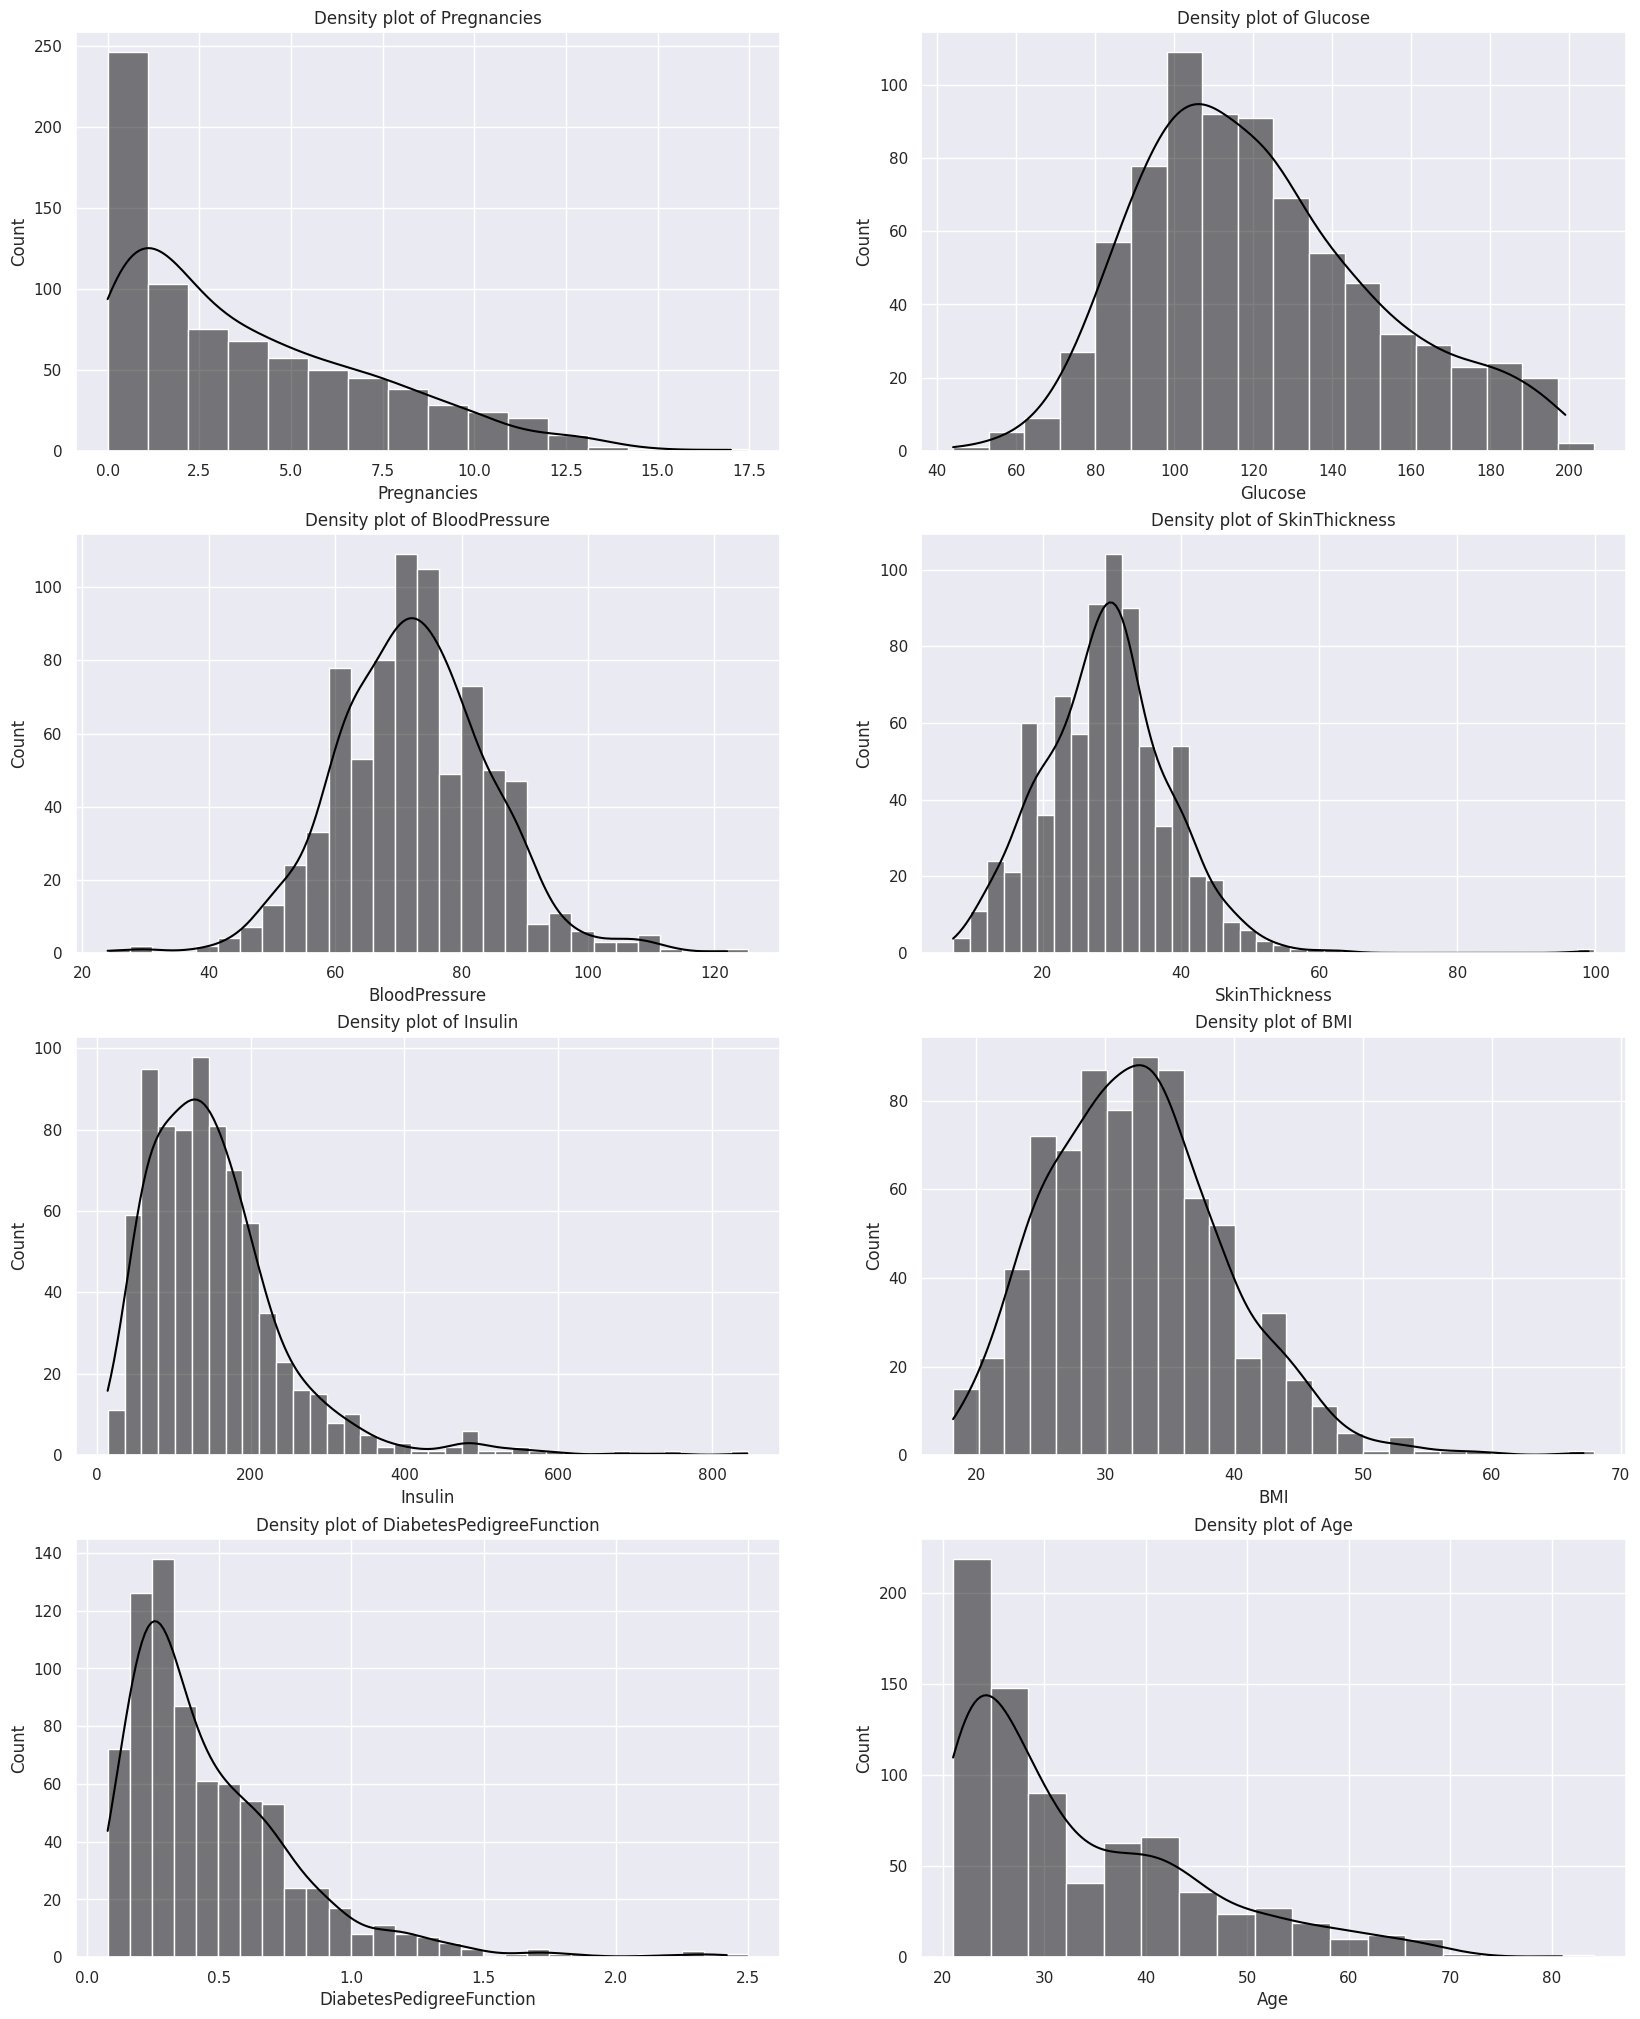

In [15]:
density(df,numerical_columns,(20,25),'black','red',4,2)

> The density plots enables us seeing the following : 
* Variable **`Pregnencies`** : Our Female patients have a preganacy number that varies between 0 and 15. The majority of our patients have between 0 and 10 pregnancies. The density can be modelisez with a Poisson distribution.
  
* Variable **`Glucose`** : The glucose level of our patients varies between 0,40 mg/dl and 200 mg/dl. The majority of our patients have a glucose level between 80 and 150. The density plot is normal.
* Variable **`BloodPressure`** : The blood pressure of our patients varies between  mm Hg and 120 mm Hg. The majority of our patients have a blood pressure between 60 and 90 mm Hg. The density plot is normal.
* Variable **`SkinThickness`** : The skin thickness of our patients varies between 0 mm and 100 mm. The majority of our patients have a skin thickness between 20 and 40 mm. The density plot is normal.
* Variable **`Insulin`** : The insulin level of our patients varies between 0 mu U/ml and 800 mu U/ml. The majority of our patients have an insulin level between 0 and 200 mu U/ml. The density plot is normal.
* Variable **`BMI`** : The BMI of our patients varies between  20 $kg/m^2$ and 70 $kg/m^2$. The majority of our patients have a BMI between 20 and 40 $kg/m^2$. The density plot is normal.
* Variable **`DiabetesPedigreeFunction`** : The diabetes pedigree function of our patients varies between 0 and 2. The majority of our patients have a diabetes pedigree function between 0 and 1. The density plot is normal.
* Variable **`Age`** : The age of our patients varies between 20 and 80 years old. The majority of our patients have an age between 20 and 40 years old. The density plot is normal.


## 🔤Qualitative Variables🔤

Text(0.5, 1.0, 'Count plot of Outcome (Diabetes, No Diabetes)')

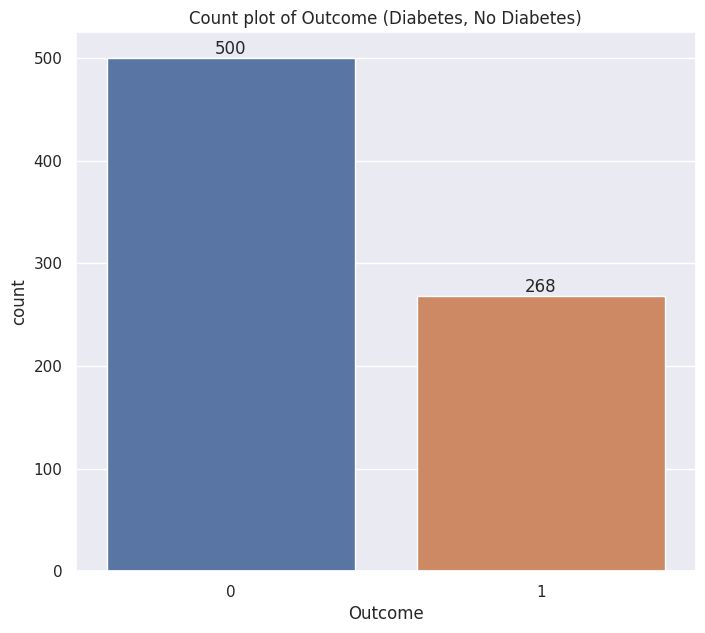

In [16]:
fig,ax=plt.subplots(1,1,figsize=(8,7))
sns.countplot(data=df_scaled,x='Outcome',axes=ax)
ax.bar_label(ax.containers[0],label_type='edge')
ax.set_title("Count plot of Outcome (Diabetes, No Diabetes)")

> We can see that the majority of our patients are non-diabetic. We have 500 non-diabetic patients and 268 diabetic patients.

## 🔄📊Bi-Variate Analysis🔄📊

### Correlation Matrix

<Axes: >

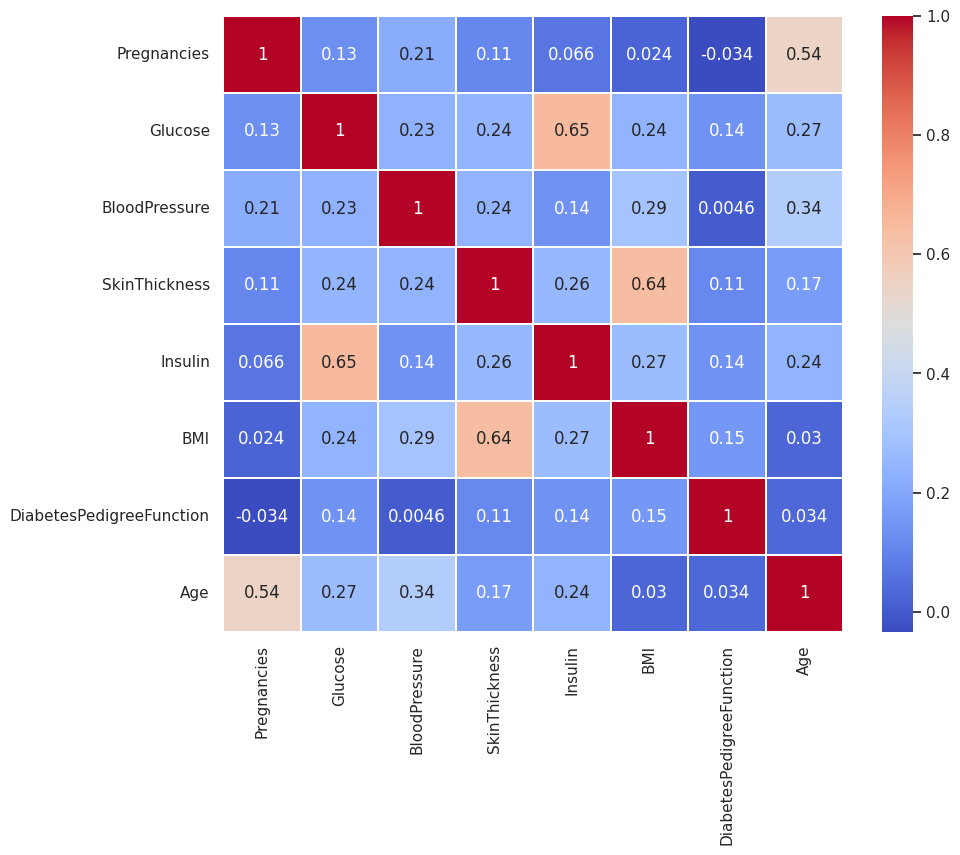

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df_scaled[numerical_columns].corr(), annot=True, cmap='coolwarm', linewidths=0.2)

> We can notice that the majority of our variables are not correlated. The only variables that are correlated are the following :

**`Glucose`** and **`Insulin`** : The correlation between these two variables is 0.65. This correlation is quite logical. Indeed, the more the glucose level is high, the more the insulin level is high.

**`SkinThickness`** and **`BMI`** : The correlation between these two variables is 0.65. This correlation is quite logical. Indeed, the fatter the patient is, the thicker the skin is.

To witness the correlation between the variables, we will make a pairplot.

### Pairplot

Text(0.5, 1.02, 'Pairplot of numerical columns colored by Oytcome')

<Figure size 1000x800 with 0 Axes>

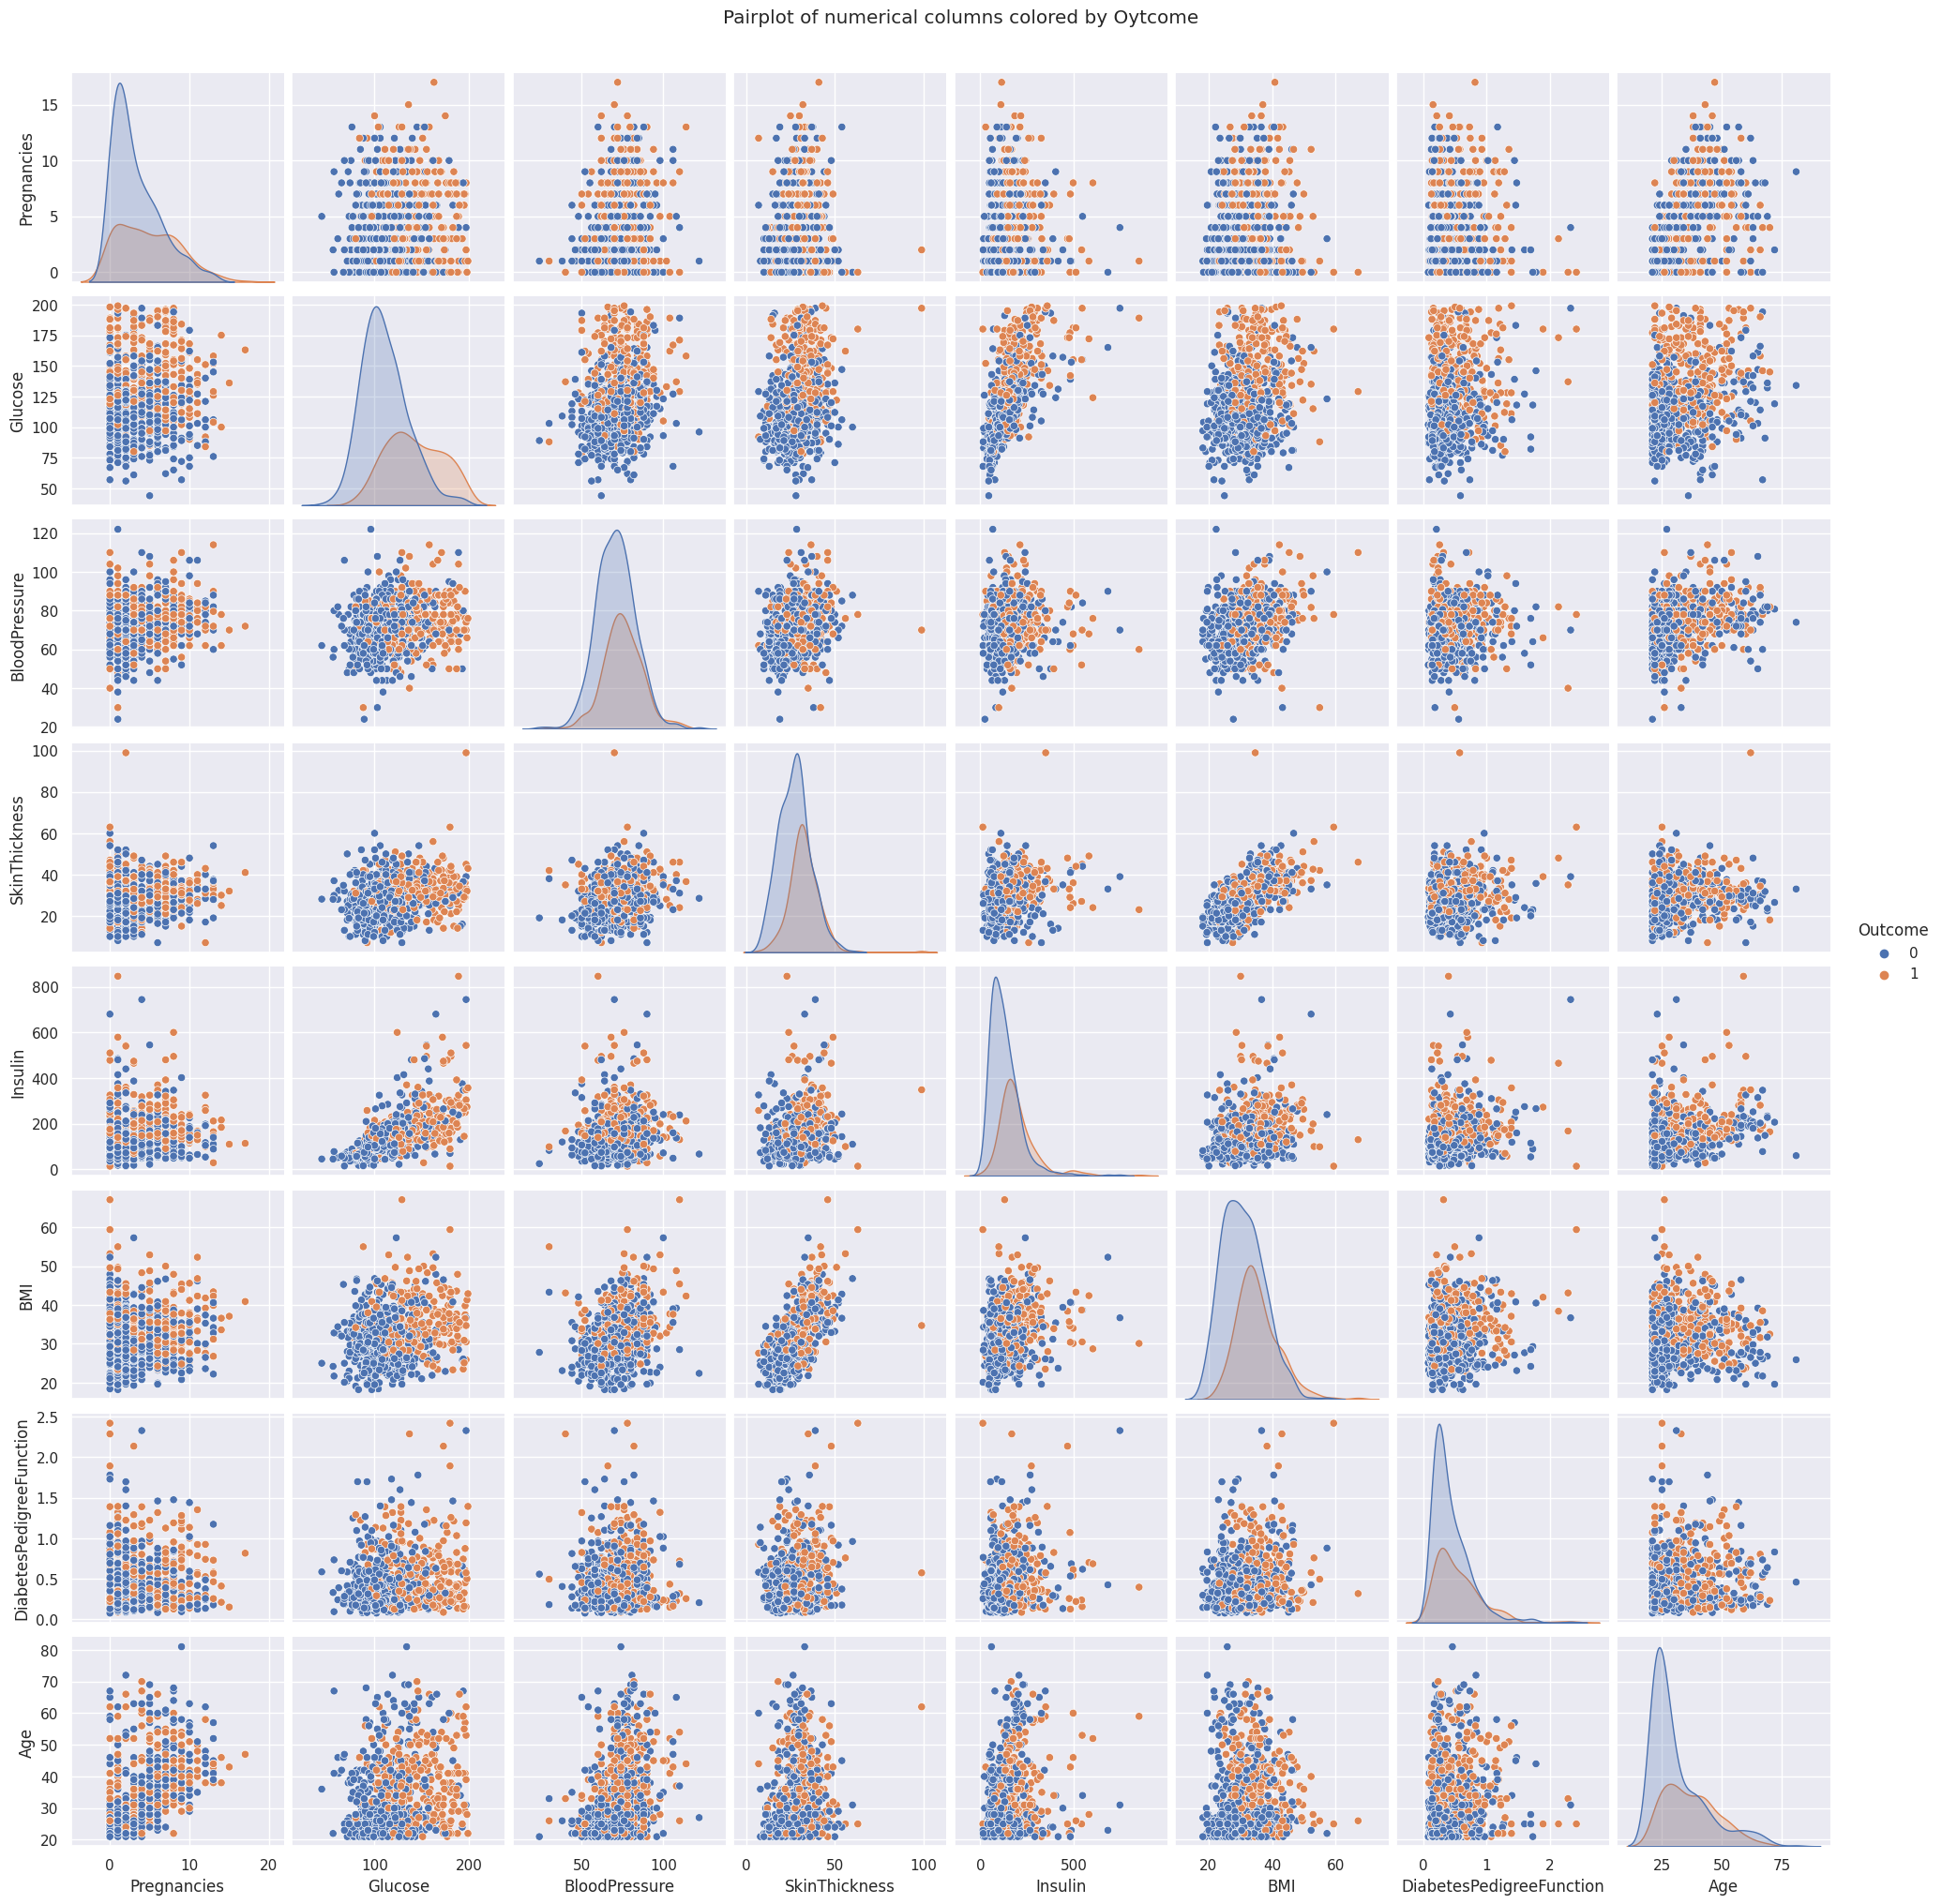

In [18]:
plt.figure(figsize=(10,8))
sns.pairplot(df,vars= numerical_columns,hue='Outcome')
plt.suptitle("Pairplot of numerical columns colored by Oytcome", y=1.02)

# 📈Méthodes factorielles📈

In this part, I am going to perform Principal Coponent Analysis (PCA) in order to see if we can reduce the dimension of the data and if we can see some differences between the brands of pizzas.

## Principal Component Analysis

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA()
pca.fit(df_scaled[numerical_columns])

PCA()

### Explained Variance

Text(0.5, 1.0, 'Cimulative Explained Variance')

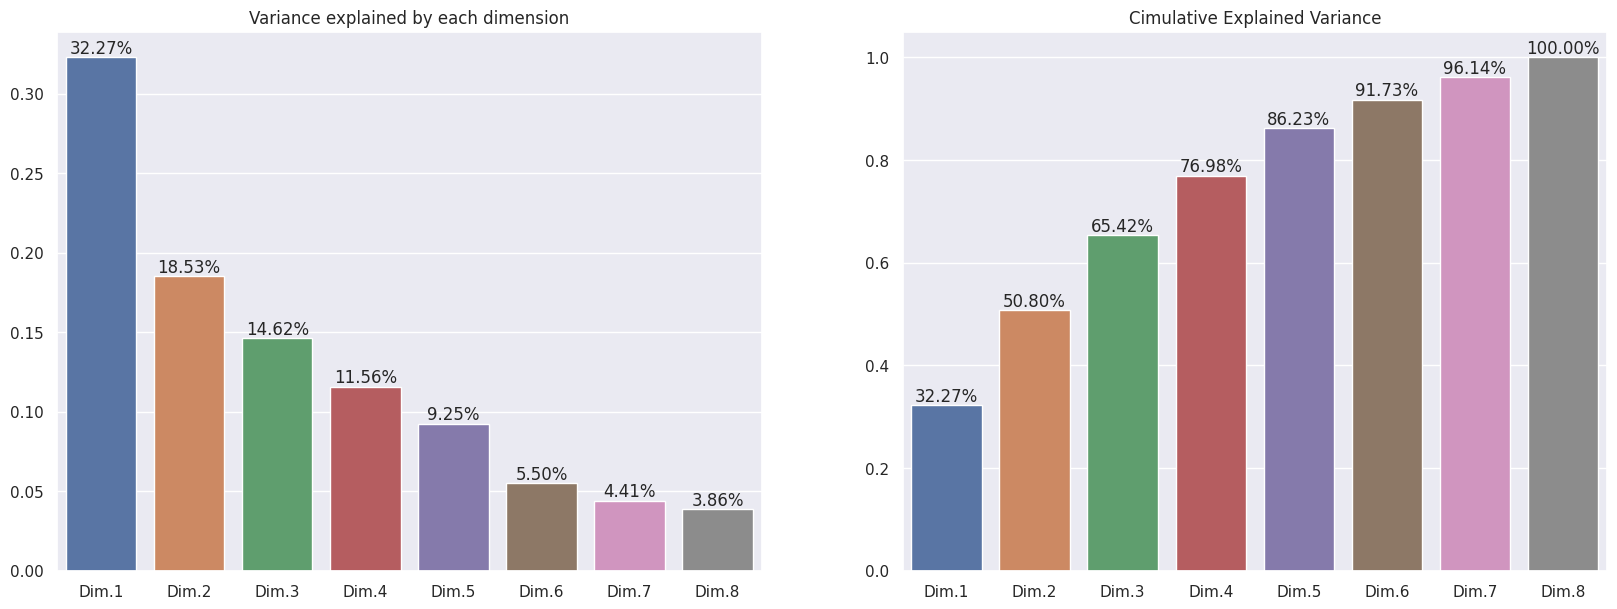

In [21]:
variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)




fig, ax = plt.subplots(1,2,figsize=(20,7))
sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=variance,ax=ax[0])
ax[0].bar_label(ax[0].containers[0], labels=[f'{val:.2%}' for val in variance], label_type='edge')
ax[0].set_title("Variance explained by each dimension")


sns.barplot(x=["Dim." + str(dim) for dim in np.arange(1, len(cumulative_variance) + 1)], y=cumulative_variance,ax=ax[1])
ax[1].bar_label(ax[1].containers[0], labels=[f'{val:.2%}' for val in cumulative_variance], label_type='edge')
ax[1].set_title("Cimulative Explained Variance")


We can deduce that we must consider 4 PCA components are enough to explain 75% of the variance of the data and therefore 75% of the information.

### Individual Factor Map

In [22]:
def pca_plot_individuals(pca,data=df,pca_variables=numerical_columns,n_pca=df.shape[0],n_plot=df.shape[0],inverse=False,markers=False,edgecolor='black',dim1=1 , dim2=2,size=(10,8),to_c = True,c_column=None,is_categorical=False,is_numerical=False):
    if n_pca < n_plot:
        n_plot = n_pca

    if is_categorical:
        is_numerical=False
    else:
        is_numerical=True
    

    subset_df = data.sample(n_pca)

    if inverse:
        inverse= -1
    else:
        inverse = +1

    C= pca.transform(subset_df[pca_variables])
    C= pd.DataFrame(C,index=subset_df.index,columns=['Dim.' + str(dim) for dim in np.arange(1, len(pca_variables) + 1)])

    plt.figure(figsize=size)
    C_sample = C.sample(n_plot)
    names=C_sample.index
    if to_c and c_column : 
        c= subset_df.loc[C_sample.index,c_column]
    
    if is_categorical:
        scatter = sns.scatterplot(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],hue=c,edgecolor=edgecolor)
    elif is_numerical:
        scatter = plt.scatter(x=C_sample[C_sample.columns[dim1-1]],y=inverse*C_sample[C_sample.columns[dim2-1]],c=c,edgecolor=edgecolor)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    if markers:
        for x,y,nom in zip(C_sample.iloc[:,0],C_sample.iloc[:,1],names):
            plt.text(x,y,nom)
    if to_c and is_numerical :
        cbar=plt.colorbar(scatter)
        cbar.ax.set_title(c_column)
    plt.title(f"Individual plot of PCA in dimensions {dim1} and {dim2}")
    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")


    plt.show()
        

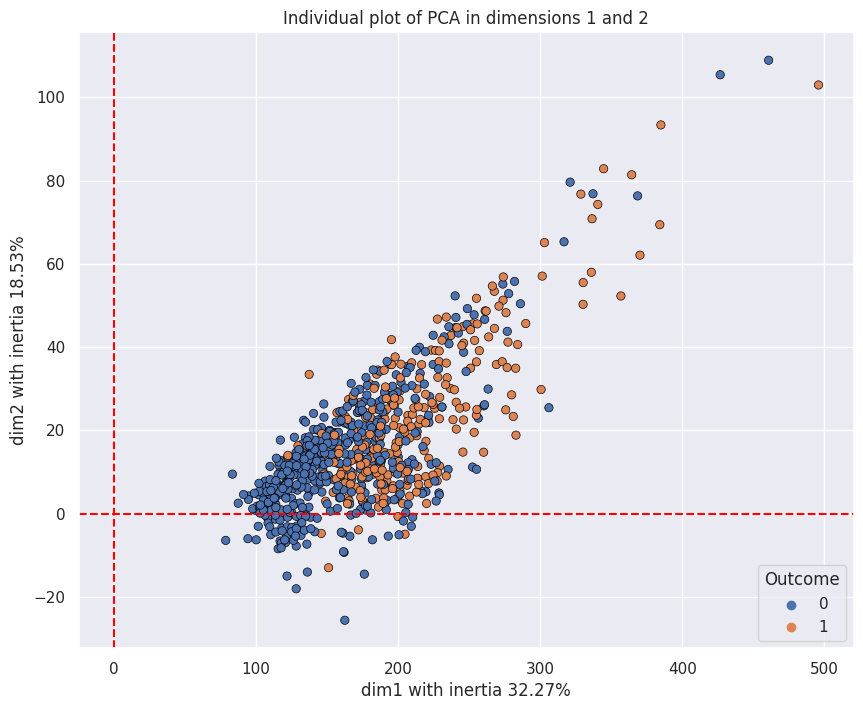

In [23]:
pca_plot_individuals(pca,to_c=True,markers=False,c_column='Outcome',size=(10,8),is_categorical=True)

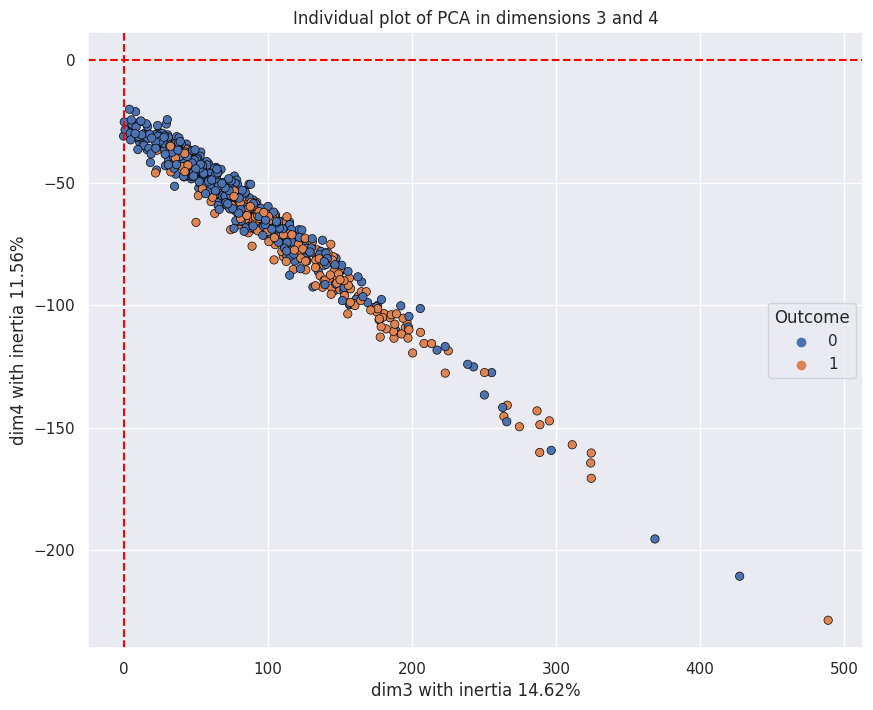

In [24]:
pca_plot_individuals(pca,to_c=True,markers=False,c_column='Outcome',size=(10,8),is_categorical=True,dim1=3,dim2=4)

### Variable Factor Map

In [25]:
def plot_pca_varcor(pca,inverse=False,data=df[numerical_columns],Legend=True,markers=True,plot_variables = numerical_columns,dim1 = 1 , dim2=2,size=(12,12)):
    if inverse:
        inverse= -1
    else:
        inverse = +1
    

    conponents = pd.DataFrame(pca.components_,columns=data.columns,index=range(0,len(pca.components_)))
    conponents = conponents[plot_variables]
    coord1 = inverse*conponents.iloc[dim1-1,:] * np.sqrt(pca.explained_variance_[dim1-1])
    coord2 = inverse*conponents.iloc[dim2-1,:] * np.sqrt(pca.explained_variance_[dim2-1])
    couleurs = plt.cm.get_cmap('tab20',len(data.columns))
    fig=plt.figure(figsize=size)
    ax=fig.add_subplot(1,1,1)
    legend = []
    head_length=0.05
    for i,j,nom,couleur in zip(coord1,coord2,plot_variables,couleurs.colors):
        legend.append(nom)
        if i >0 and j >0 :
            angle = np.arctan(j/i)
        elif i<0 and j >0 :
            angle = np.pi + np.arctan(j/i)
        elif i>0 and j <0 :
            angle =  np.arctan(j/i)
        elif i<0 and j <0 :
            angle = np.arctan(j/i)
        else:
            angle = 0
        if markers:
            plt.text(i,j,nom,fontsize=15)
        
        plt.arrow(0,0,i-head_length * np.cos(angle),j-head_length * np.sin(angle),color=couleur,head_width=0.05,label=nom,head_length=0.05)

    plt.axis((-1.2,1.2,-1.2,1.2))
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    c=plt.Circle((0,0),radius=1,color='blue',fill=False)


    plt.xlabel(f"dim{dim1} with inertia {pca.explained_variance_ratio_[dim1-1]:.2%}")
    plt.ylabel(f"dim{dim2} with inertia {pca.explained_variance_ratio_[dim2-1]:.2%}")
    plt.title(f"Variable correlation in dimensions {dim1} and {dim2}")
    ax.add_patch(c)
    if Legend:
       plt.legend(plot_variables,loc='best')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.show()



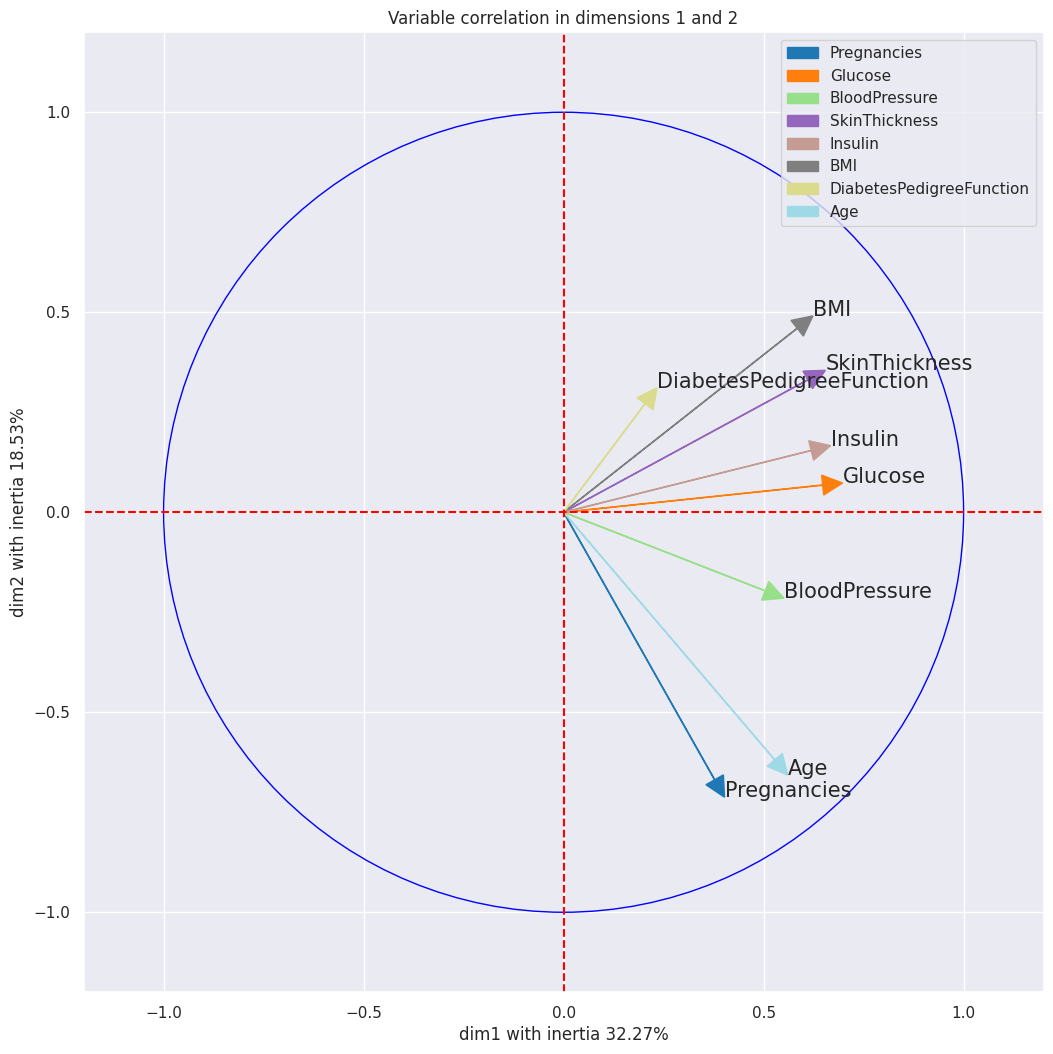

In [26]:
plot_pca_varcor(pca,markers=True,size=(12,12))

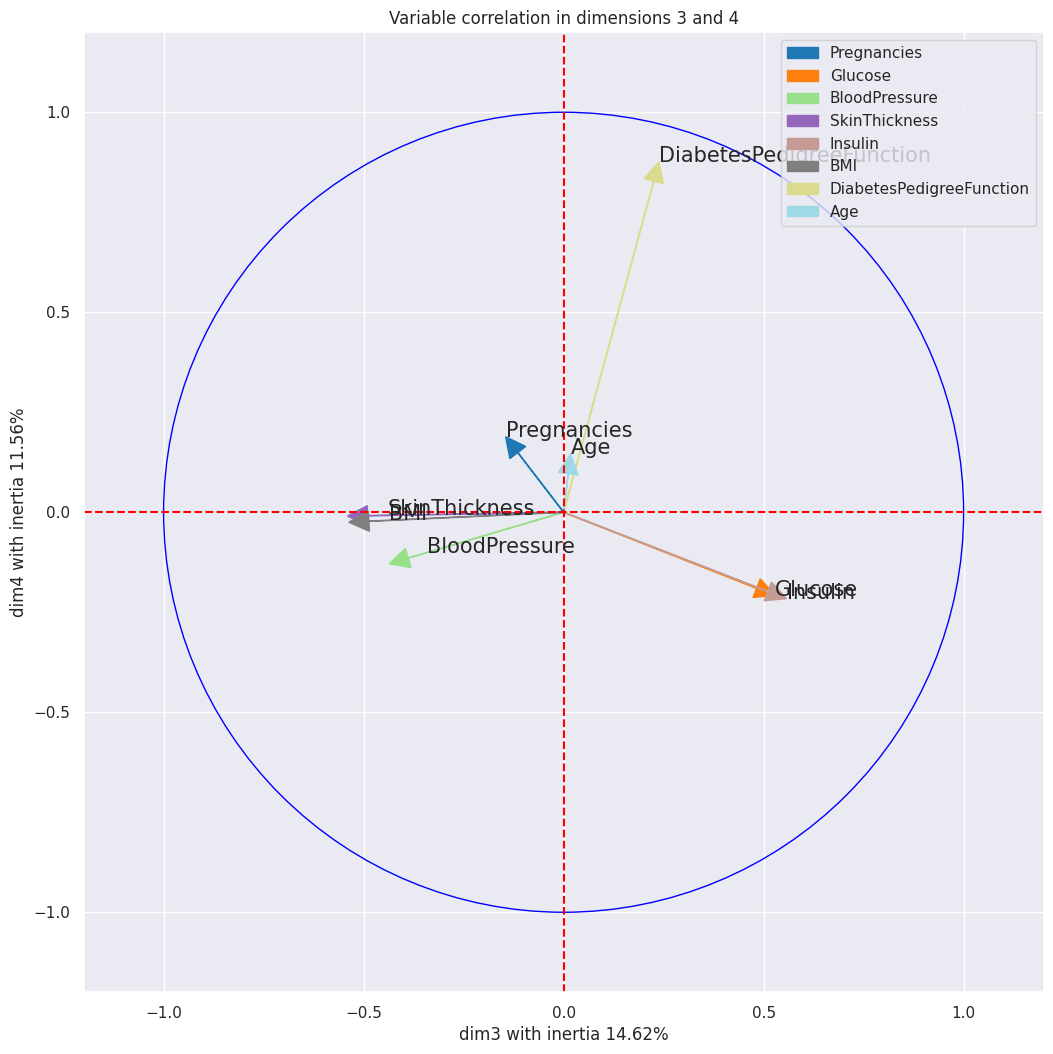

In [27]:
plot_pca_varcor(pca,markers=True,size=(12,12),dim1=3,dim2=4)

In orther to see if we can better separate the brands, we will perform a Linear Discriminant Analysis (LDA).

# Linear Discriminant Analysis

In [28]:
df_lda = df_scaled.copy()


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

features = df_lda.drop('Outcome', axis=1)
target = df['Outcome']
method = LinearDiscriminantAnalysis()

X_train, X_test ,Y_train,Y_test = train_test_split(features, target, test_size=0.6)
lda = method.fit(X_train, Y_train)
X_r2 = lda.transform(X_train)

## Predicting the Outcome using LDA

### Splitting the Data

In [29]:
import time

method = LinearDiscriminantAnalysis()
ts = time.time()
method.fit(X_train, Y_train)
scoreLDA = method.score(X_test, Y_test)
ypredLDA = method.predict(X_test)
te = time.time()

### Predicting the Outcome

Score : 0.783080, time running : 0 secondes


Text(0.5, 1.0, 'Confusion matrix of LDA')

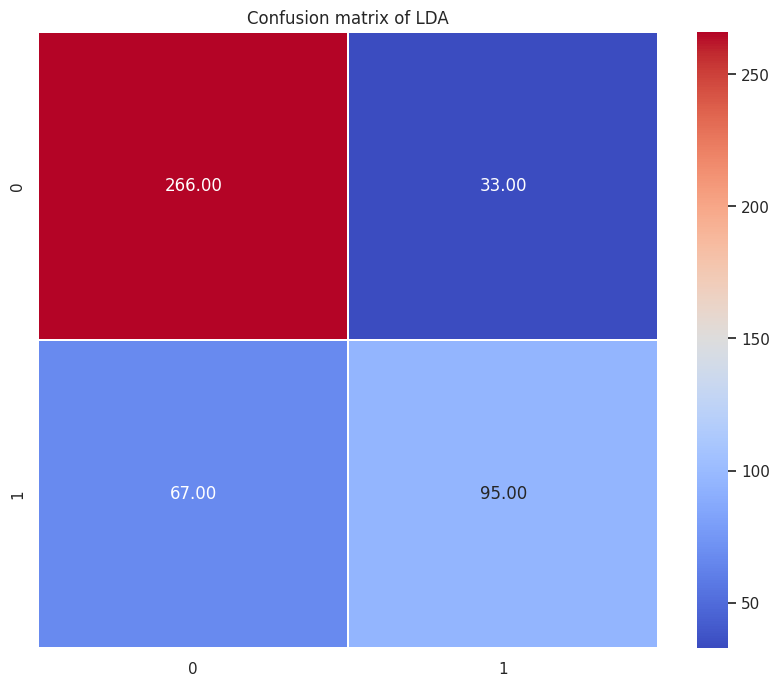

In [30]:
from sklearn.metrics import confusion_matrix
print("Score : %f, time running : %d secondes" %(scoreLDA, te - ts))
labels=np.unique(Y_test)
plt.figure(figsize=(10,8))
confusion_matrix_=pd.DataFrame(confusion_matrix(Y_test, ypredLDA),index=labels,columns=labels)
sns.heatmap(confusion_matrix_,annot=True,cmap='coolwarm',linewidths=0.1,fmt=".2f")
plt.title("Confusion matrix of LDA")

Score : 0.783080, time running : 0 secondes


Text(0.5, 1.0, 'Normalized confusion matrix of LDA')

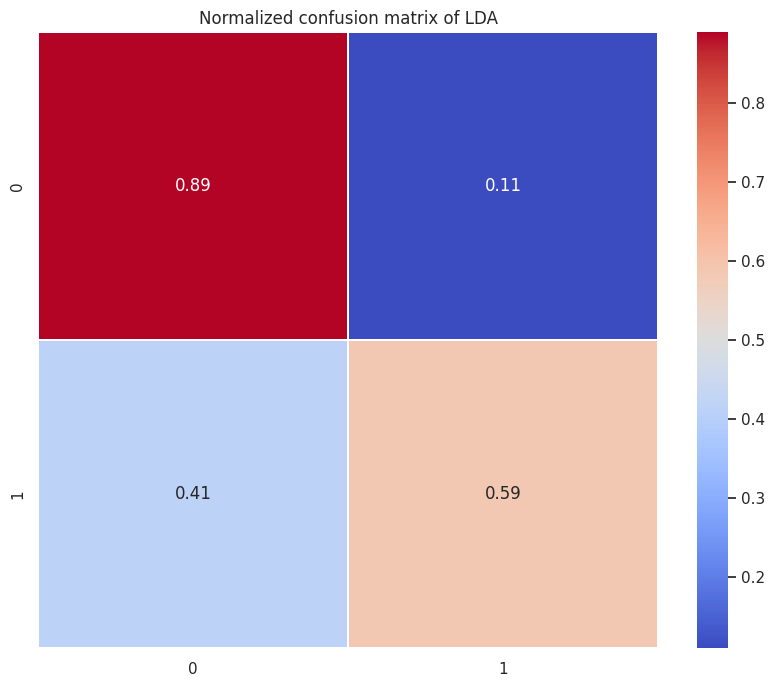

In [31]:
print("Score : %f, time running : %d secondes" %(scoreLDA, te - ts))
labels=np.unique(Y_test)
plt.figure(figsize=(10,8))

# Compute confusion matrix
cm = confusion_matrix(Y_test, ypredLDA)

# Normalize by row (i.e., by the true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

confusion_matrix_=pd.DataFrame(cm_normalized, index=labels, columns=labels)
sns.heatmap(confusion_matrix_, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title("Normalized confusion matrix of LDA")

> We can see that our Global Score is 78%. However, LDA finds it much more harder to detect the positive Cases.
>
> The reason why LDA finds it harder to detect the positive cases is because the Data dont have the same covariance matrix when considereing each class.
>
> For that reason, we are going to apply a Logistic Regression.

# Logistic Regression




In [32]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
method = LogisticRegression(penalty='none')
method.fit(X_train, Y_train)
scoreLR = method.score(X_test, Y_test)
ypredLR = method.predict(X_test)
te = time.time()

Score : 0.774403, time running : 0 secondes


Text(0.5, 1.0, 'Normalized confusion matrix of LDA')

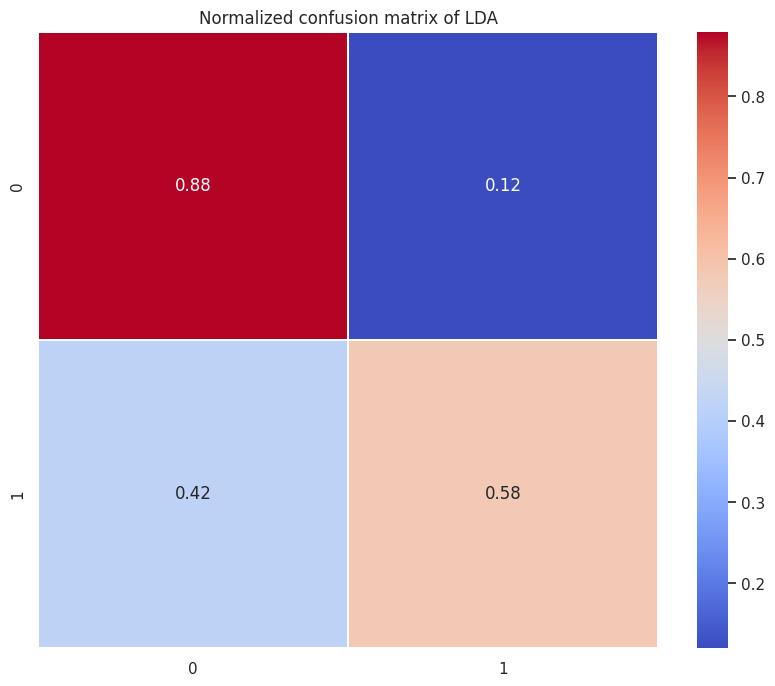

In [33]:
print("Score : %f, time running : %d secondes" %(scoreLR, te - ts))
labels=np.unique(Y_test)
plt.figure(figsize=(10,8))

# Compute confusion matrix
cm = confusion_matrix(Y_test, ypredLR)

# Normalize by row (i.e., by the true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

confusion_matrix=pd.DataFrame(cm_normalized, index=labels, columns=labels)
sns.heatmap(confusion_matrix, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title("Normalized confusion matrix of LDA")

> We see that the Global Score is 78%. The Logistic did worse than the LDA.
>
>In order to know why the Logistic Regression did worse than the LDA. We will see if the variables in our DataSet are able to explain the Outcome.  

In [34]:
import statsmodels.api as sm
df_LR = df_scaled.copy()
df_LR['intercept'] = 1
Y= df_LR['Outcome']
df_LR.drop('Outcome',axis=1,inplace=True)
modeladditif = sm.Logit(Y, df_LR)
result = modeladditif.fit()

Optimization terminated successfully.
         Current function value: 0.462602
         Iterations 6


In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Thu, 23 Nov 2023   Pseudo R-squ.:                  0.2848
Time:                        22:44:56   Log-Likelihood:                -355.28
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 1.763e-56
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.4116      0.109      3.761      0.000       0.197       0.626
Glucose                      1.1577      0.131      8.814      0.000       0.900       1.415
BloodPressure               -0.1228      0.105     -1.172      0.241      -0.328       0.083
SkinThickness                0.1357      0.128      1.063      0.288      -0.114       0.386
Insulin                     -0.0793      0.118     -0.672      0.502      -0.311       0.152
BMI                          0.5841      0.132      4.410      0.000       0.324       0.844
DiabetesPedigreeFunction     0.2886      0.099      2.928      0.003       0.095       0.482
Age                          0.1551      0.114      1.366      0.172      -0.067       0.378
intercept                   -0.8693      0.098     -8.884      0.000      -1.061      -0.678
============================================================================================
"""

> We can deduce the following :
>
> Almost all the variables are necessary in explaining the Outcome. At a risk of 5%, we can reject the null hypothesis for all the variables except the variable **`BloodPressure`** , **`SkinThickness`** and **`Insulin`** and **`Age`** ( However, we must not banish all the varibales at once at a time. We must banish them one by one and redo the test each time we banish a variable).